[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mariyamuneeb/ssl_wordspotting/blob/main/VariationalAE.ipynb)

## Project Setup

In [1]:
import os
!git clone https://github.com/mariyamuneeb/ssl_wordspotting
os.chdir('/content/ssl_wordspotting')
!pip install -qqq wandb

from setup_wandb import wandb_login
wandb_login()

Cloning into 'ssl_wordspotting'...
remote: Enumerating objects: 284, done.
remote: Counting objects: 100% (284/284), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 284 (delta 158), reused 180 (delta 75), pack-reused 0
Receiving objects: 100% (284/284), 7.27 MiB | 5.22 MiB/s, done.
Resolving deltas: 100% (158/158), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.1/189.1 KB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 4.3 MB/s eta 0:00:00
/content/ssl_wordspotting
Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [2]:
import torch

In [3]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import wandb
import numpy as np
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Standard Datasets

## Initialization

In [ ]:
num_channels = 3
base_channel_size=32
lr = 10e-2
latent_dim = 384
epochs = 300
plot_freq = 10

wandb.init(
      # Set the project where this run will be logged
      project="SSL", 
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"VAE", 
      # Track hyperparameters and run metadata
      config={
      "architecture": "CNN",
      "dataset": "CIFAR-10",
      "epochs": epochs,
      "latent_dim":latent_dim
      })

In [ ]:
torch.manual_seed(0)

# d = 4

vae = VariationalAutoencoder(latent_dims=4)

optim = torch.optim.Adam(vae.parameters(), lr=lr)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

vae.to(device)

## Import/Load Datasets

In [ ]:
data_dir = 'dataset'
# train_dataset = torchvision.datasets.MNIST(data_dir, train = True, download = True)
# test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_dataset = torchvision.datasets.CIFAR10(data_dir,train=True,download=True)
test_dataset  = torchvision.datasets.CIFAR10(data_dir,train=False, download=True)

In [ ]:
img = train_dataset[1][0]
label = train_dataset[1][1]
print(img.mode)
print(label)
plt.imshow(img)
plt.show()

In [ ]:
img.size

In [ ]:
train_transform = transforms.Compose([transforms.ToTensor(), ])

test_transform = transforms.Compose([transforms.ToTensor(), ])

In [ ]:
train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

VariationalAutoencoder class, which combines the Encoder and Decoder classes 
The encoder and decoder networks contain **three convolutional layers** and **two fully connected layers**. 
Some batch normal layers are added to have more robust features in the latent space. 
Differently from the standard autoencoder, the **encoder returns mean and variance matrices** and we use them to obtain the sampled latent vector. 

## Training Loop

In [ ]:
for epoch in range(epochs):
   train_loss = train_epoch(vae,device,train_loader,optim)
   val_loss = test_epoch(vae,device,valid_loader)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, epochs,train_loss,val_loss))
   if epoch%plot_freq==0:
       plot_ae_outputs(vae.encoder,vae.decoder,n=10)

In [ ]:
break

In [ ]:
train_loader

# VAE on Hand-written Dataset 

## Dataset

### Connect to GDrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
PATH = '/content/drive/MyDrive/Datasets/tif'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Imports

In [ ]:
import os
import cv2
import math
from PIL import Image
import matplotlib.pyplot as plt
from statistics import mean
from math import floor

### Custom Dataset Definition

In [ ]:
images_paths = [os.path.join(PATH,i) for i in os.listdir(PATH)]
split = 0.85
train_idx = math.floor(split*len(images_paths))
train_images = images_paths[:train_idx]
test_images = images_paths[train_idx:]

### Plotting Few Images

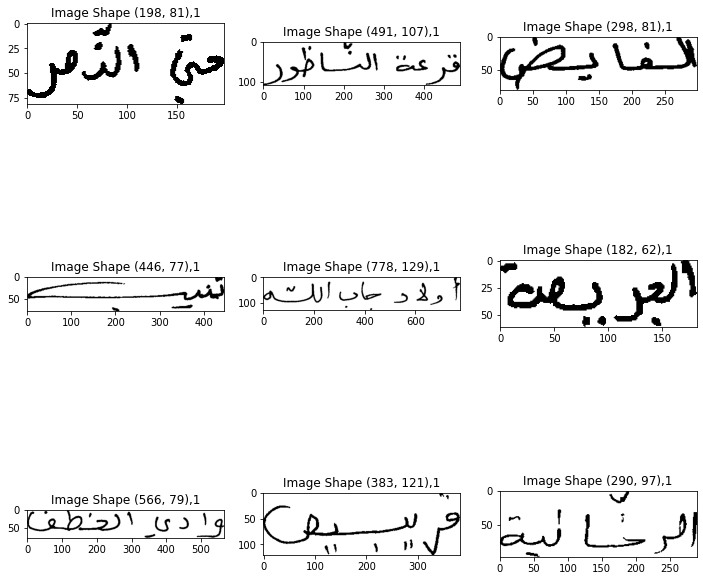

In [ ]:
random_imgs = random.sample(train_images, 9)
random_imgs = [Image.open(i) for i in random_imgs]
_, axs = plt.subplots(3, 3, figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(random_imgs, axs):
    ax.imshow(img)
    ax.title.set_text(f'Image Shape {img.size},{img.mode}')
plt.show()

### Finding Ave Image Dimensions

In [ ]:
h_list = list()
w_list = list()

for p in train_images:
    h_list.append(Image.open(p).size[1])
    w_list.append(Image.open(p).size[0])
num_channels = int(Image.open(p).mode)

h_ave = floor(mean(h_list))
w_ave = floor(mean(w_list))
# resize_size = (h_ave,w_ave)
resize_size = (128,128)

### Dataset Definitions

In [ ]:
train_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Resize(resize_size),])
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize(resize_size),])

hw_train_dataset = MyDataset(img_paths=train_images,transform=train_transform)
hw_test_dataset = MyDataset(img_paths=test_images,transform=test_transform)

NameError: ignored

### Dataloader and Batching Definitions

In [ ]:
m=len(hw_train_dataset)


batch_size=8

train_loader = torch.utils.data.DataLoader(hw_train_dataset, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(hw_test_dataset, batch_size=batch_size)

## Plotting

## Initialization

### Hyperparameters

In [ ]:
base_channel_size = 32
lr = 1e-3
latent_dim = 512
epochs = 300
plot_freq = 10

In [ ]:
hw_train_dataset[0][0].shape

### W&B Init

In [ ]:
wandb.init(
      # Set the project where this run will be logged
      project="SSL", 
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"VAE", 
      # Track hyperparameters and run metadata
      config={
      "architecture": "CNN",
      "dataset": "Hand Written Dataset",
      "lr":lr,
      "epochs": epochs,
      "latent_dim":latent_dim
      })

### Initialize VAE

Initialize the VariationalAutoencoder class, the optimizer, and the device to use the GPU in the code.

In [ ]:
torch.manual_seed(0)

vae = VariationalAutoencoder(num_channels,base_channel_size,latent_dim)
print(vae)

optim = torch.optim.Adam(vae.parameters(), lr=lr)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')
vae.to(device)

## Training

### Train Loop

In [ ]:
for epoch in range(epochs):
   train_loss = train_epoch(vae,device,train_loader,optim)
   val_loss = test_epoch(vae,device,valid_loader)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, epochs,train_loss,val_loss))
   if epoch%plot_freq==0:
       plot_ae_custom_ds_outputs(vae.encoder,vae.decoder,hw_test_dataset,n=10)

# IAM Dataset


## Dataset

In [4]:
from models.dataset_utils import IAMDataset2,IAMDataset,IAMSubset
from models.layers import VariationalEncoder,Decoder
from experiment_utils.utils import train_epoch,test_epoch
from PIL import Image
from math import floor
from statistics import mean

### Copy Dataset to Colab Instance

In [5]:
from data_utils.utils import copy_iam_dataset_to_colab
copy_iam_dataset_to_colab()

Copying IAM Dataset from GDrive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/ssl_wordspotting/data/IAM_HW/words.tgz now copied
/content/ssl_wordspotting/data/IAM_HW/xml.tgz now copied
/content/ssl_wordspotting/data/IAM_HW/rules.zip now copied
Copied IAM HW Files


In [ ]:
# train_dir = '/content/ssl_wordspotting/data/words_training'
# test_dir = '/content/ssl_wordspotting/data/words_test'

In [6]:
resize_size = (128,128)
train_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Resize(resize_size),])
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize(resize_size),])
iam_train_dataset = IAMDataset2('train',transform=train_transform)
iam_test_dataset = IAMDataset2('test',transform=train_transform)


In [15]:
subset_iam_train_dataset = IAMSubset().subset(iam_train_dataset,0.2)
subset_iam_test_dataset = IAMSubset().subset(iam_test_dataset,0.2)

### Plot Few Samples

In [16]:
from data_utils.plotting import plot_iam_samples,plot_reconstructions,plot_iam_reconstructions
# plot_iam_samples(iam_train_dataset,9)

In [17]:
batch_size=256

train_loader = torch.utils.data.DataLoader(subset_iam_train_dataset, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(subset_iam_test_dataset, batch_size=batch_size)

## Initialization

### HyperParameters

In [18]:
base_channel_size = 32
num_channels = 3
lr = 1e-3
latent_dim = 512
epochs = 150
plot_freq = 10

### W&B Init

In [19]:
wandb.init(
      # Set the project where this run will be logged
      project="SSL", 
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"IAM VAE", 
      # Track hyperparameters and run metadata
      config={
      "architecture": "CNN",
      "dataset": "IAM Hand Written Dataset",
      "lr":lr,
      "epochs": epochs,
      "latent_dim":latent_dim
      })

### Define VAE

In [20]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, num_channels, base_channel_size, latent_dim):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(num_channels, base_channel_size, latent_dim)
        self.decoder = Decoder(num_channels, base_channel_size, latent_dim)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

### Initialize VAE

In [21]:
torch.manual_seed(0)

vae = VariationalAutoencoder(num_channels,base_channel_size,latent_dim)

vae.to(device)
optim = torch.optim.Adam(vae.parameters(), lr=lr)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')


Selected device: cuda


## Training

### Train Loop

In [22]:
for epoch in range(epochs):
   train_loss = train_epoch(vae,device,train_loader,optim)
   val_loss = test_epoch(vae,device,valid_loader)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, epochs,train_loss,val_loss))
   if epoch%plot_freq==0:
       plot_reconstructions(vae.encoder,vae.decoder,iam_test_dataset,device, n=10)
       

RuntimeError: ignored

In [ ]:
device

## Initialization

### HyperParameters

In [23]:
base_channel_size = 32
num_channels = 1
lr = 1e-3
latent_dim = 512
epochs = 150
plot_freq = 10

### W&B Init

In [24]:
wandb.init(
      # Set the project where this run will be logged
      project="SSL", 
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"IAM VAE", 
      # Track hyperparameters and run metadata
      config={
      "architecture": "CNN",
      "dataset": "IAM Hand Written Dataset",
      "lr":lr,
      "epochs": epochs,
      "latent_dim":latent_dim
      })

### Define VAE

In [25]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, num_channels, base_channel_size, latent_dim):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(num_channels, base_channel_size, latent_dim)
        self.decoder = Decoder(num_channels, base_channel_size, latent_dim)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

### Initialize VAE

In [26]:
torch.manual_seed(0)

vae = VariationalAutoencoder(num_channels,base_channel_size,latent_dim)

vae.to(device)
optim = torch.optim.Adam(vae.parameters(), lr=lr)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')


Selected device: cuda


## Training

### Train Loop


 EPOCH 1/150 	 train loss 3787.556 	 val loss 1611.102


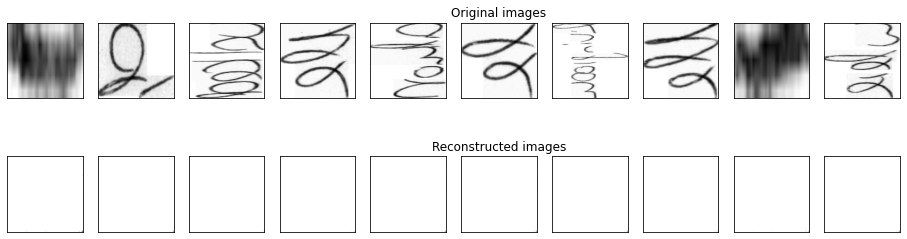


 EPOCH 2/150 	 train loss 1654.679 	 val loss 1602.102

 EPOCH 3/150 	 train loss 1649.255 	 val loss 1588.178

 EPOCH 4/150 	 train loss 1503.891 	 val loss 1271.861

 EPOCH 5/150 	 train loss 1140.616 	 val loss 1001.466

 EPOCH 6/150 	 train loss 1032.019 	 val loss 979.448

 EPOCH 7/150 	 train loss 1010.572 	 val loss 962.388

 EPOCH 8/150 	 train loss 986.552 	 val loss 947.478

 EPOCH 9/150 	 train loss 967.654 	 val loss 919.524

 EPOCH 10/150 	 train loss 946.767 	 val loss 927.910

 EPOCH 11/150 	 train loss 944.214 	 val loss 890.223


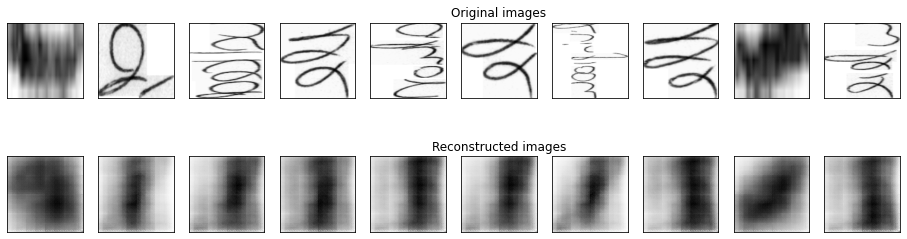


 EPOCH 12/150 	 train loss 927.672 	 val loss 882.120

 EPOCH 13/150 	 train loss 923.127 	 val loss 877.370

 EPOCH 14/150 	 train loss 921.892 	 val loss 874.784

 EPOCH 15/150 	 train loss 912.099 	 val loss 868.686

 EPOCH 16/150 	 train loss 901.477 	 val loss 857.534

 EPOCH 17/150 	 train loss 893.269 	 val loss 875.200

 EPOCH 18/150 	 train loss 894.237 	 val loss 846.532

 EPOCH 19/150 	 train loss 880.660 	 val loss 850.872

 EPOCH 20/150 	 train loss 878.948 	 val loss 843.895

 EPOCH 21/150 	 train loss 873.460 	 val loss 833.639


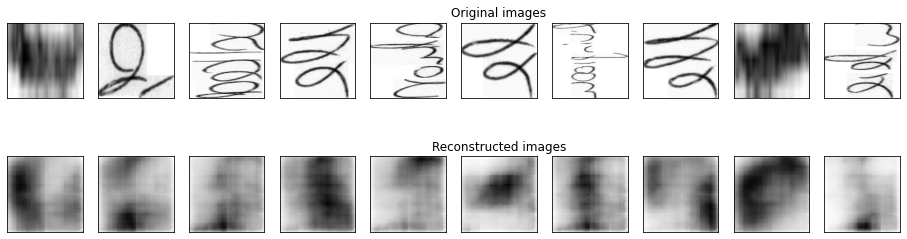


 EPOCH 22/150 	 train loss 867.766 	 val loss 833.776

 EPOCH 23/150 	 train loss 866.117 	 val loss 815.868

 EPOCH 24/150 	 train loss 855.721 	 val loss 812.032

 EPOCH 25/150 	 train loss 850.154 	 val loss 807.653

 EPOCH 26/150 	 train loss 843.343 	 val loss 803.593

 EPOCH 27/150 	 train loss 836.885 	 val loss 793.869

 EPOCH 28/150 	 train loss 831.074 	 val loss 785.180

 EPOCH 29/150 	 train loss 824.322 	 val loss 786.838

 EPOCH 30/150 	 train loss 820.346 	 val loss 776.125

 EPOCH 31/150 	 train loss 814.136 	 val loss 775.553


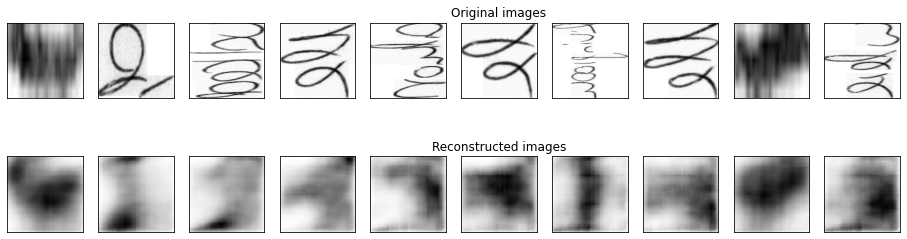


 EPOCH 32/150 	 train loss 807.821 	 val loss 766.234

 EPOCH 33/150 	 train loss 800.753 	 val loss 753.977

 EPOCH 34/150 	 train loss 794.647 	 val loss 754.525

 EPOCH 35/150 	 train loss 790.028 	 val loss 746.480

 EPOCH 36/150 	 train loss 784.634 	 val loss 750.199

 EPOCH 37/150 	 train loss 780.709 	 val loss 741.209

 EPOCH 38/150 	 train loss 775.027 	 val loss 734.163

 EPOCH 39/150 	 train loss 769.916 	 val loss 733.039

 EPOCH 40/150 	 train loss 768.268 	 val loss 726.675

 EPOCH 41/150 	 train loss 762.245 	 val loss 741.798


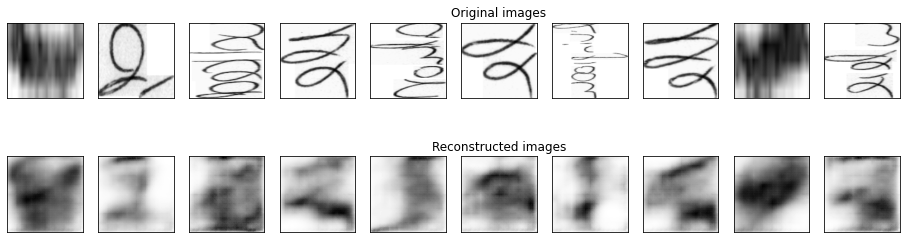


 EPOCH 42/150 	 train loss 764.628 	 val loss 724.850

 EPOCH 43/150 	 train loss 756.750 	 val loss 719.093

 EPOCH 44/150 	 train loss 751.206 	 val loss 717.919

 EPOCH 45/150 	 train loss 746.291 	 val loss 712.741

 EPOCH 46/150 	 train loss 742.093 	 val loss 710.077

 EPOCH 47/150 	 train loss 737.461 	 val loss 705.615

 EPOCH 48/150 	 train loss 733.896 	 val loss 704.461

 EPOCH 49/150 	 train loss 730.363 	 val loss 701.928

 EPOCH 50/150 	 train loss 727.230 	 val loss 702.132

 EPOCH 51/150 	 train loss 724.545 	 val loss 697.906


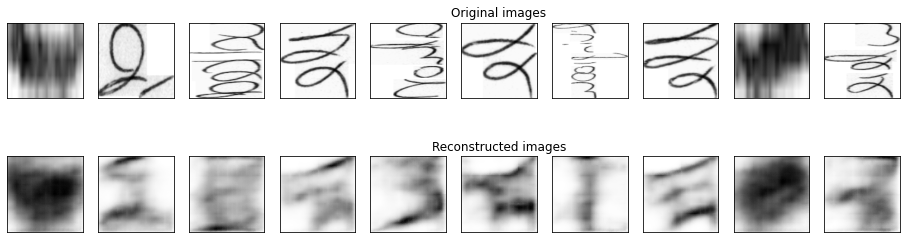


 EPOCH 52/150 	 train loss 721.113 	 val loss 707.103

 EPOCH 53/150 	 train loss 721.571 	 val loss 694.824

 EPOCH 54/150 	 train loss 711.257 	 val loss 692.768

 EPOCH 55/150 	 train loss 707.832 	 val loss 694.965

 EPOCH 56/150 	 train loss 704.820 	 val loss 689.582

 EPOCH 57/150 	 train loss 701.315 	 val loss 687.545

 EPOCH 58/150 	 train loss 697.170 	 val loss 686.766

 EPOCH 59/150 	 train loss 694.421 	 val loss 687.552

 EPOCH 60/150 	 train loss 691.907 	 val loss 682.052

 EPOCH 61/150 	 train loss 691.140 	 val loss 689.462


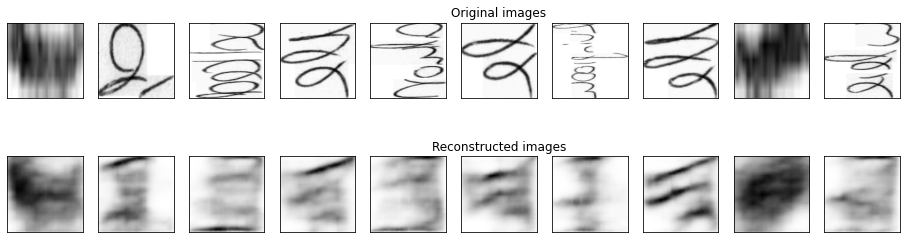


 EPOCH 62/150 	 train loss 692.883 	 val loss 737.846

 EPOCH 63/150 	 train loss 704.963 	 val loss 860.029

 EPOCH 64/150 	 train loss 718.186 	 val loss 688.354

 EPOCH 65/150 	 train loss 685.269 	 val loss 674.881

 EPOCH 66/150 	 train loss 674.408 	 val loss 677.357

 EPOCH 67/150 	 train loss 670.643 	 val loss 672.518

 EPOCH 68/150 	 train loss 664.913 	 val loss 674.862

 EPOCH 69/150 	 train loss 661.460 	 val loss 681.455

 EPOCH 70/150 	 train loss 657.733 	 val loss 676.871

 EPOCH 71/150 	 train loss 653.111 	 val loss 674.472


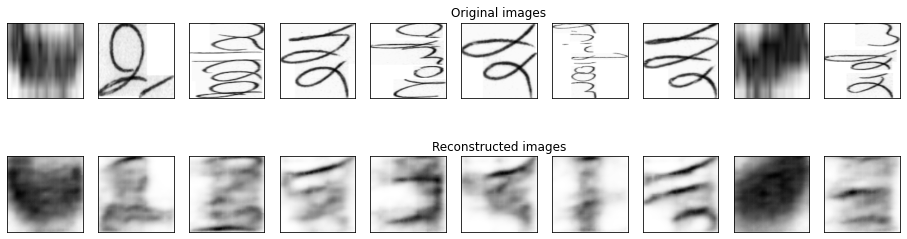


 EPOCH 72/150 	 train loss 649.676 	 val loss 681.665

 EPOCH 73/150 	 train loss 646.472 	 val loss 678.568

 EPOCH 74/150 	 train loss 642.969 	 val loss 680.646

 EPOCH 75/150 	 train loss 640.216 	 val loss 689.414

 EPOCH 76/150 	 train loss 639.416 	 val loss 678.461

 EPOCH 77/150 	 train loss 639.767 	 val loss 681.345

 EPOCH 78/150 	 train loss 644.680 	 val loss 774.749

 EPOCH 79/150 	 train loss 651.092 	 val loss 673.608

 EPOCH 80/150 	 train loss 634.493 	 val loss 674.991

 EPOCH 81/150 	 train loss 630.270 	 val loss 684.324


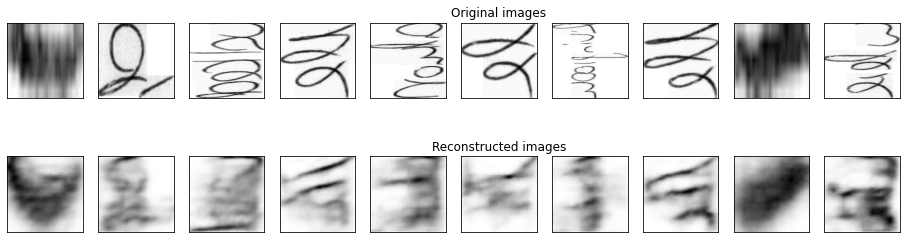


 EPOCH 82/150 	 train loss 629.328 	 val loss 707.410

 EPOCH 83/150 	 train loss 630.517 	 val loss 745.870

 EPOCH 84/150 	 train loss 636.136 	 val loss 682.379

 EPOCH 85/150 	 train loss 634.958 	 val loss 709.346

 EPOCH 86/150 	 train loss 626.083 	 val loss 696.063

 EPOCH 87/150 	 train loss 620.261 	 val loss 686.704

 EPOCH 88/150 	 train loss 621.875 	 val loss 703.650

 EPOCH 89/150 	 train loss 616.016 	 val loss 726.748

 EPOCH 90/150 	 train loss 606.904 	 val loss 682.045

 EPOCH 91/150 	 train loss 596.630 	 val loss 681.676


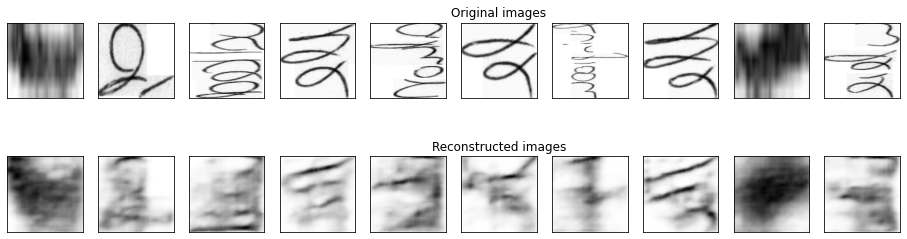


 EPOCH 92/150 	 train loss 587.905 	 val loss 687.168

 EPOCH 93/150 	 train loss 584.622 	 val loss 687.880

 EPOCH 94/150 	 train loss 583.223 	 val loss 697.499

 EPOCH 95/150 	 train loss 578.806 	 val loss 697.675

 EPOCH 96/150 	 train loss 574.744 	 val loss 716.255

 EPOCH 97/150 	 train loss 572.699 	 val loss 698.404

 EPOCH 98/150 	 train loss 571.578 	 val loss 706.719

 EPOCH 99/150 	 train loss 568.689 	 val loss 710.291

 EPOCH 100/150 	 train loss 569.389 	 val loss 703.317

 EPOCH 101/150 	 train loss 570.210 	 val loss 757.938


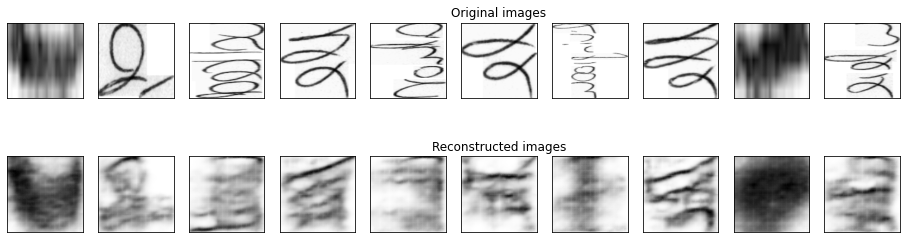


 EPOCH 102/150 	 train loss 574.334 	 val loss 769.684

 EPOCH 103/150 	 train loss 580.402 	 val loss 712.680

 EPOCH 104/150 	 train loss 593.748 	 val loss 698.949

 EPOCH 105/150 	 train loss 579.781 	 val loss 701.070

 EPOCH 106/150 	 train loss 586.010 	 val loss 732.812

 EPOCH 107/150 	 train loss 602.963 	 val loss 746.518

 EPOCH 108/150 	 train loss 589.921 	 val loss 701.895

 EPOCH 109/150 	 train loss 555.678 	 val loss 695.287

 EPOCH 110/150 	 train loss 540.973 	 val loss 696.795

 EPOCH 111/150 	 train loss 535.571 	 val loss 692.804


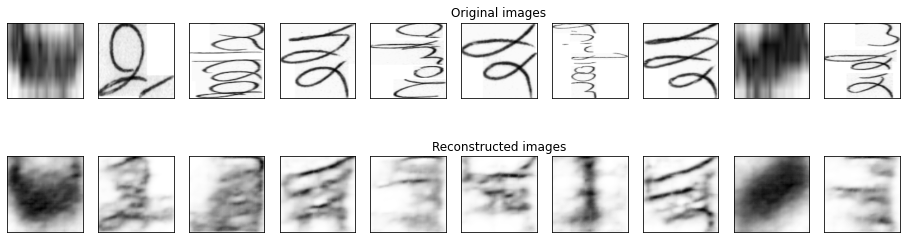


 EPOCH 112/150 	 train loss 532.679 	 val loss 698.432

 EPOCH 113/150 	 train loss 533.009 	 val loss 700.548

 EPOCH 114/150 	 train loss 534.361 	 val loss 691.427

 EPOCH 115/150 	 train loss 536.868 	 val loss 706.013

 EPOCH 116/150 	 train loss 535.794 	 val loss 720.964

 EPOCH 117/150 	 train loss 531.539 	 val loss 707.939

 EPOCH 118/150 	 train loss 531.156 	 val loss 706.057

 EPOCH 119/150 	 train loss 528.864 	 val loss 708.780

 EPOCH 120/150 	 train loss 526.610 	 val loss 704.933

 EPOCH 121/150 	 train loss 527.326 	 val loss 712.206


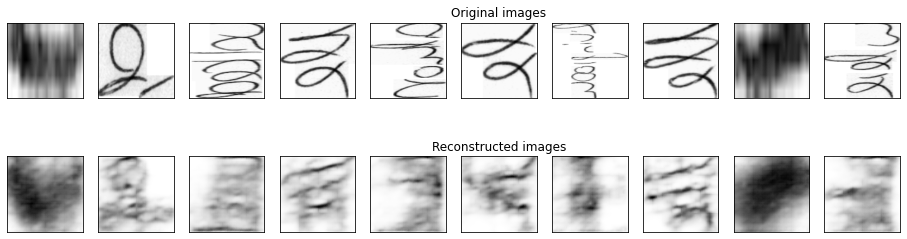


 EPOCH 122/150 	 train loss 532.538 	 val loss 719.342

 EPOCH 123/150 	 train loss 537.860 	 val loss 745.006

 EPOCH 124/150 	 train loss 535.256 	 val loss 770.896

 EPOCH 125/150 	 train loss 533.592 	 val loss 804.628

 EPOCH 126/150 	 train loss 532.743 	 val loss 784.670

 EPOCH 127/150 	 train loss 537.694 	 val loss 787.149

 EPOCH 128/150 	 train loss 548.244 	 val loss 738.735

 EPOCH 129/150 	 train loss 547.112 	 val loss 725.030

 EPOCH 130/150 	 train loss 546.357 	 val loss 735.951

 EPOCH 131/150 	 train loss 533.937 	 val loss 731.794


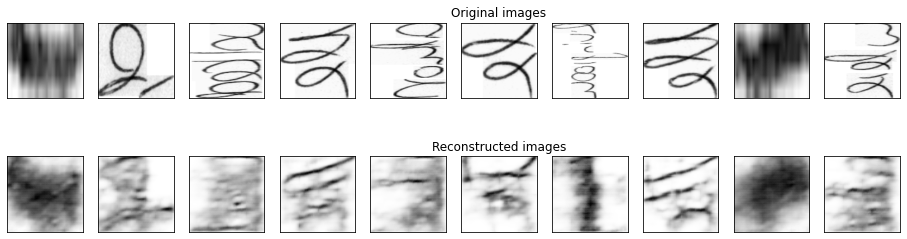


 EPOCH 132/150 	 train loss 519.899 	 val loss 733.149

 EPOCH 133/150 	 train loss 508.468 	 val loss 737.824

 EPOCH 134/150 	 train loss 503.202 	 val loss 735.650

 EPOCH 135/150 	 train loss 499.942 	 val loss 745.789

 EPOCH 136/150 	 train loss 501.559 	 val loss 744.600

 EPOCH 137/150 	 train loss 501.124 	 val loss 752.325

 EPOCH 138/150 	 train loss 504.021 	 val loss 757.815

 EPOCH 139/150 	 train loss 505.668 	 val loss 748.992

 EPOCH 140/150 	 train loss 507.736 	 val loss 759.534

 EPOCH 141/150 	 train loss 508.694 	 val loss 757.134


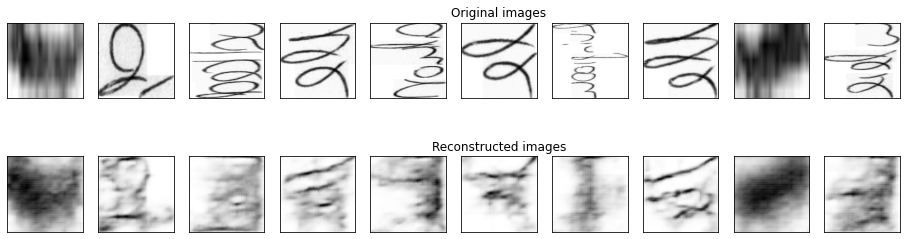


 EPOCH 142/150 	 train loss 509.966 	 val loss 774.800

 EPOCH 143/150 	 train loss 512.238 	 val loss 776.975

 EPOCH 144/150 	 train loss 516.955 	 val loss 772.325

 EPOCH 145/150 	 train loss 540.666 	 val loss 775.169

 EPOCH 146/150 	 train loss 571.128 	 val loss 786.700

 EPOCH 147/150 	 train loss 568.903 	 val loss 833.885

 EPOCH 148/150 	 train loss 522.673 	 val loss 795.181

 EPOCH 149/150 	 train loss 492.368 	 val loss 778.513

 EPOCH 150/150 	 train loss 481.779 	 val loss 765.855


In [27]:
for epoch in range(epochs):
    train_loss = train_epoch(vae,device,train_loader,optim)
    val_loss = test_epoch(vae,device,valid_loader)
    
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, epochs,train_loss,val_loss))
    if epoch%plot_freq==0:
        plot_iam_reconstructions(vae.encoder,vae.decoder,iam_test_dataset,device,'IAM HW', n=10)
        
        ## save model here
        ## run evaluation of MAP

In [28]:
PATH = '/content/drive/MyDrive/Mariyah_Phd/weights/vae_weights.pt'
torch.save(model, PATH)

NameError: ignored

In [ ]:
!pwd

In [ ]:
def plot_iam_reconstructions(encoder, decoder, test_dataset, device, dataset_name, n=10):
    wandb_imgs = list()
    wandb_rec_imgs = list()
    my_table = wandb.Table(columns=["Original", "Reconstruction"])
    plt.figure(figsize=(16, 4.5))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        _, img, _ = test_dataset[i]
        img = img.unsqueeze(0).to(device)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img = decoder(encoder(img))
        plt.imshow(img.cpu().squeeze().numpy().T, cmap='gist_gray')  # for MNIST remove the transpose
        #   plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray') # for MNIST remove the transpose
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title('Original images')
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(rec_img.cpu().squeeze().numpy().T, cmap='gist_gray')  # for MNIST remove the transpose
        #   plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  #for MNIST remove the transpose
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title('Reconstructed images')
        my_table.add_data(wandb.Image(img.cpu()), wandb.Image(rec_img.cpu()))
        wandb_imgs.append(img.cpu())
        wandb_rec_imgs.append(rec_img.cpu())
    plt.show()
    wandb.log({dataset_name: my_table})

In [ ]:
plot_iam_reconstructions(vae.encoder,vae.decoder,subset_iam_test_dataset,device,'IAM HW', n=10)

In [ ]:
def plot_iam_reconstructions(encoder, decoder, test_dataset, device, dataset_name, n=10):
    wandb_imgs = list()
    wandb_rec_imgs = list()
    my_table = wandb.Table(columns=["Original", "Reconstruction"])
    plt.figure(figsize=(16, 4.5))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        _, img, _ = test_dataset[i]
        img = img.unsqueeze(0).to(device)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img = decoder(encoder(img))
        plt.imshow(img.cpu().squeeze().numpy().T, cmap='gist_gray')  # for MNIST remove the transpose
        #   plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray') # for MNIST remove the transpose
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title('Original images')
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(rec_img.cpu().squeeze().numpy().T, cmap='gist_gray')  # for MNIST remove the transpose
        #   plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  #for MNIST remove the transpose
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title('Reconstructed images')
        my_table.add_data(wandb.Image(img.cpu()), wandb.Image(rec_img.cpu()))
        wandb_imgs.append(img.cpu())
        wandb_rec_imgs.append(rec_img.cpu())
    plt.show()
    wandb.log({dataset_name: my_table})

In [ ]:
plot_iam_reconstructions(vae.encoder,vae.decoder,subset_iam_test_dataset,device,'IAM HW', n=10)

/content/ssl_wordspotting


In [30]:
def plot_iam_reconstructions(encoder, decoder, test_dataset, device, dataset_name, n=10):
    wandb_imgs = list()
    wandb_rec_imgs = list()
    my_table = wandb.Table(columns=["Original", "Reconstruction"])
    plt.figure(figsize=(16, 4.5))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        _, img, _ = test_dataset[i]
        img = img.unsqueeze(0).to(device)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img = decoder(encoder(img))
        plt.imshow(img.cpu().squeeze().numpy().T, cmap='gist_gray')  # for MNIST remove the transpose
        #   plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray') # for MNIST remove the transpose
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title('Original images')
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(rec_img.cpu().squeeze().numpy().T, cmap='gist_gray')  # for MNIST remove the transpose
        #   plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  #for MNIST remove the transpose
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title('Reconstructed images')
        my_table.add_data(wandb.Image(img.cpu()), wandb.Image(rec_img.cpu()))
        wandb_imgs.append(img.cpu())
        wandb_rec_imgs.append(rec_img.cpu())
    plt.show()
    wandb.log({dataset_name: my_table})

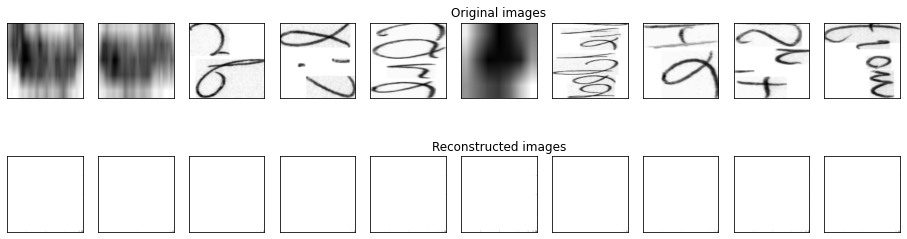

In [21]:
plot_iam_reconstructions(vae.encoder,vae.decoder,subset_iam_test_dataset,device,'IAM HW', n=10)